In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
%matplotlib inline

def plot(ax, data, enum=False, title='', labels=None, legend=False, **kwargs):
    if enum:
        ax.plot(data)
    else:
        mapping = np.array(data).T
        ax.plot(mapping[0], mapping[1], **kwargs)
    if labels:
        ax.set_xlabel(labels[0])
        if (len(labels) > 1):
            ax.set_ylabel(labels[1])
    if legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ax.set_title(title)
    ax.grid(True)

def scatter(ax, data, enum=False, title='', labels=None, legend=False, **kwargs):
    if enum:
        ax.scatter(range(len(data)), data, **kwargs)
    else:
        mapping = np.array(data).T
        ax.scatter(mapping[0], mapping[1], **kwargs)
    if labels:
        ax.set_xlabel(labels[0])
        if (len(labels) > 1):
            ax.set_ylabel(labels[1])
    if legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ax.set_title(title)
    ax.grid(True)

In [1]:
# Exercise 2: Compare three learning procedures
#   1. Gradient descent with constant learning rate
#   2. Steepest descent combined with a line search (to determine the learning rate)
#   3. Conjugate gradient method
training_set = np.array([(-1, -0.1), (0.3, 0.5), (2, 0.5)])  # (x_alpha. t_alpha)

class LearningProcedure:
    
    def __init__(self, X=training_set, epochs_max=100, seed=137):
        np.random.seed(seed)
        self.epochs_max = epochs_max
        self.ws = np.zeros((epochs_max + 1, 2))
        self.X = X
        self.xa = X[:, 0].reshape(3, 1)
        self.ta = X[:, 1].reshape(3, 1)
        self.w = np.random.uniform(-0.5, 0.5, 2).T
        # Matrix with biases and inputs
        self.X_xa = np.append(np.ones((len(self.xa), 1)), self.xa, axis=1).T
        self.H = self.hessian()
        self.b = self.gradient_bias()
        self.g = self.gradient()
        t = 0
        self.errors = []
    
    def hessian(self):
        return self.X_xa.dot(self.X_xa.T)
    
    def gradient_bias(self):
        return self.X_xa.dot(self.ta)
    
    def gradient(self):
        g = self.H.dot(self.w) - self.b
        return g[0]
    
    def error(self):
        # Quadratic error function
        diff = self.w.T.dot(self.X_xa)[0] - self.ta.T
        err = 0.5 * diff.dot(diff.T)
        return err[0, 0]
    
    def run(self, convergence=1e-100, plot=True):
        epoch = 0
        while (epoch < self.epochs_max and any(self.g != 0) and
               (len(self.errors) < 3 or self.errors[-2] - self.errors[-1] > convergence)):
            self.ws[epoch] = self.w.reshape(2)
            self.errors.append(self.error())
            self.update()
            self.g = self.gradient()
            epoch += 1
        self.ws[epoch] = self.w.reshape(2)
        self.errors.append(self.error())
        self.ws = self.ws[~np.all(self.ws == 0, axis=1)]
        self.plot()
        
    def update(self):
        raise NotImplementedError('You have to implement a learning method')
    
    def plot(self):        
        fig, ax = plt.subplots(1, 3, figsize=(13, 4))
        plot(ax[0], self.errors, enum=True, labels=['Iterations', 'Quadratic error'], title='Final error: {:.4f}'.format(self.errors[-1]))
        scatter(ax[1], self.ws, labels=['w0', 'w1'], title=self.__class__.__name__)
        scatter(ax[2], self.ws.T[0], enum=True, label='w0')
        scatter(ax[2], self.ws.T[1], enum=True, label='w1', color='red', title='Weights', legend=True, labels=['Iterations'])
        fig.tight_layout()

NameError: name 'np' is not defined

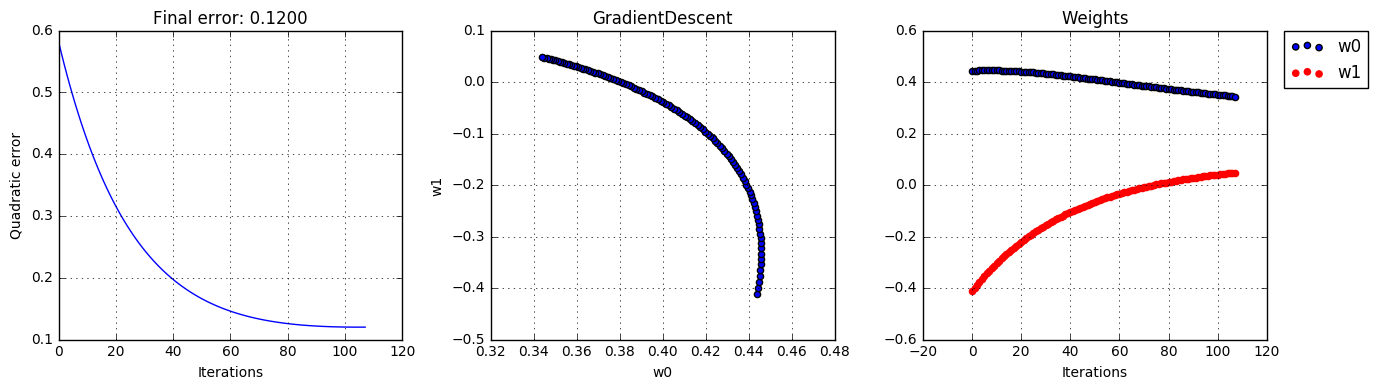

In [709]:
# Gradient_descent
class GradientDescent(LearningProcedure):
    
    def __init__(self, X=training_set, epochs_max=300, eta=0.005):
        super().__init__(X, epochs_max)
        self.eta = eta
    
    def update(self):
        self.w -= self.eta * self.g

# Best value at about (0.2, 0.2)
GradientDescent().run(convergence=0)

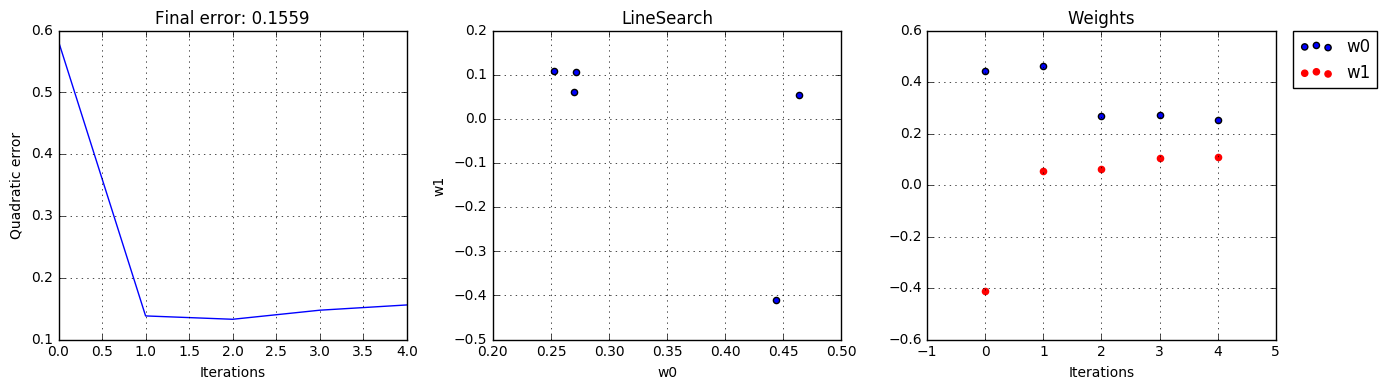

In [697]:
# b) Line search
class LineSearch(LearningProcedure):
    
    def calc_eta(self):
        # eta = - (g.T * g) / (g.T * H * g)
        return self.g.T.dot(self.g) / self.g.T.dot(self.H).dot(self.g)

    def update(self):
        self.w -= self.calc_eta() * self.g

LineSearch().run()

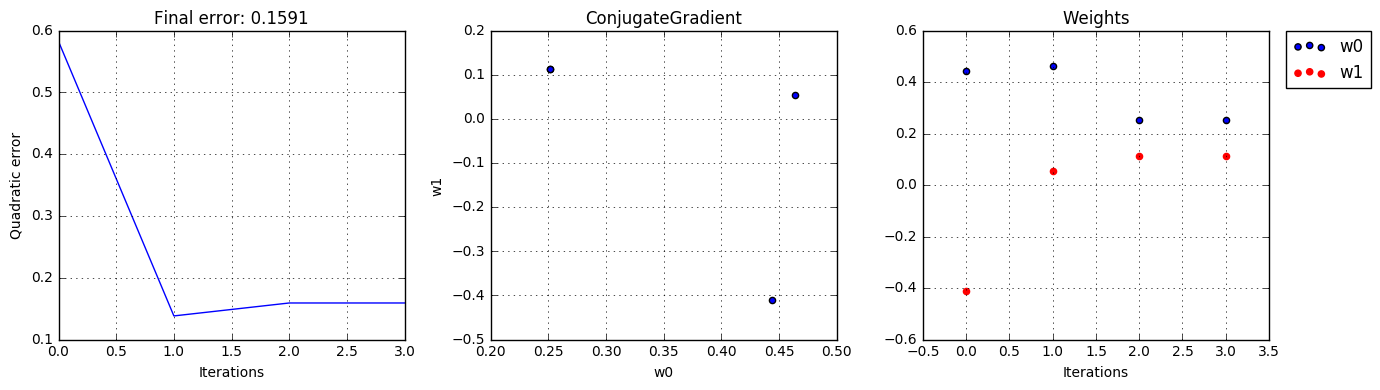

In [696]:
# c) Conjugate gradient
class ConjugateGradient(LearningProcedure):
    
    def __init__(self, X=training_set, epochs_max=60):
        super().__init__(X, epochs_max)
        self.d = self.g * (-1.0)
    
    def calc_eta(self):
        # eta = - (d.T * g_old) / (d.T * H * d)
        return (-1.0) * self.d.T.dot(self.old_g) / self.d.T.dot(self.H).dot(self.d)

    def calc_beta(self):
        # beta = - (g.T * g) / (g_old.T * g_old)
        return (-1.0) * self.g.T.dot(self.g) / self.old_g.T.dot(self.old_g)  
    
    def update(self):
        self.old_g = self.g
        # Optimize error function along d
        self.w += self.calc_eta() * self.d
        self.g = self.gradient()
        # New conjugate direction
        self.d = self.g + self.calc_beta() * self.d

ConjugateGradient().run()
# In theory ConjugateGradient should Converge after 2 iterations (in 2D space)